# 图像拼接

In [21]:
%matplotlib inline
import matplotlib.pyplot as plt
import cv2
import numpy as np
import time

In [14]:
src = cv2.imread('../datas/stitching-1.jpg')
rgb1 = cv2.cvtColor(src,cv2.COLOR_BGR2RGB)
src2 = cv2.imread('../datas/stitching-2.jpg')
rgb2 = cv2.cvtColor(src2,cv2.COLOR_BGR2RGB)
src3 = cv2.imread('../datas/stitching-3.jpg')
rgb3 = cv2.cvtColor(src3,cv2.COLOR_BGR2RGB)

In [3]:
# Use the keypoints to stitch the images
def get_stitched_image(img1, img2, M):

	# Get width and height of input images	
	w1,h1 = img1.shape[:2]
	w2,h2 = img2.shape[:2]

	# Get the canvas dimesions
	img1_dims = np.float32([ [0,0], [0,w1], [h1, w1], [h1,0] ]).reshape(-1,1,2)
	img2_dims_temp = np.float32([ [0,0], [0,w2], [h2, w2], [h2,0] ]).reshape(-1,1,2)


	# Get relative perspective of second image
	img2_dims = cv2.perspectiveTransform(img2_dims_temp, M)

	# Resulting dimensions
	result_dims = np.concatenate( (img1_dims, img2_dims), axis = 0)

	# Getting images together
	# Calculate dimensions of match points
	[x_min, y_min] = np.int32(result_dims.min(axis=0).ravel() - 0.5)
	[x_max, y_max] = np.int32(result_dims.max(axis=0).ravel() + 0.5)
	
	# Create output array after affine transformation 
	transform_dist = [-x_min,-y_min]
	transform_array = np.array([[1, 0, transform_dist[0]], 
								[0, 1, transform_dist[1]], 
								[0,0,1]]) 

	# Warp images to get the resulting image
	result_img = cv2.warpPerspective(img2, transform_array.dot(M), 
									(x_max-x_min, y_max-y_min))
	result_img[transform_dist[1]:w1+transform_dist[1], 
				transform_dist[0]:h1+transform_dist[0]] = img1

	# Return the result
	return result_img

In [11]:
# Find SIFT and return Homography Matrix
def get_sift_homography(img1, img2):

	# Initialize SIFT 
	sift = cv2.xfeatures2d.SIFT_create()

	# Extract keypoints and descriptors
	k1, d1 = sift.detectAndCompute(img1, None)
	k2, d2 = sift.detectAndCompute(img2, None)

	# Bruteforce matcher on the descriptors
	bf = cv2.BFMatcher()
	matches = bf.knnMatch(d1,d2, k=2)

	# Make sure that the matches are good
	verify_ratio = 0.8 # Source: stackoverflow
	verified_matches = []
	for m1,m2 in matches:
		# Add to array only if it's a good match
		if m1.distance < 0.8 * m2.distance:
			verified_matches.append(m1)

	# Mimnum number of matches
	min_matches = 8
	if len(verified_matches) > min_matches:
		
		# Array to store matching points
		img1_pts = []
		img2_pts = []

		# Add matching points to array
		for match in verified_matches:
			img1_pts.append(k1[match.queryIdx].pt)
			img2_pts.append(k2[match.trainIdx].pt)
		img1_pts = np.float32(img1_pts).reshape(-1,1,2)
		img2_pts = np.float32(img2_pts).reshape(-1,1,2)
		
		# Compute homography matrix
		M, mask = cv2.findHomography(img1_pts, img2_pts, cv2.RANSAC, 5.0)
		return M
	else:
		print('Error: Not enough matches')
		exit()

# Equalize Histogram of Color Images
def equalize_histogram_color(img):
	img_yuv = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)
	img_yuv[:,:,0] = cv2.equalizeHist(img_yuv[:,:,0])
	img = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2BGR)
	return img

In [15]:
# Equalize histogram
img1 = equalize_histogram_color(rgb1)
img2 = equalize_histogram_color(rgb2)
img3 = equalize_histogram_color(rgb3)
M =  get_sift_homography(img1, img2)
result_image = get_stitched_image(img2, img1, M)

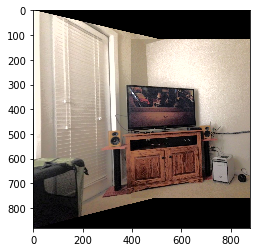

In [13]:
plt.imshow(result_image)

In [20]:
class matchers:
	def __init__(self):
		self.surf = cv2.xfeatures2d.SURF_create()
		FLANN_INDEX_KDTREE = 0
		index_params = dict(algorithm=0, trees=5)
		search_params = dict(checks=50)
		self.flann = cv2.FlannBasedMatcher(index_params, search_params)

	def match(self, i1, i2, direction=None):
		imageSet1 = self.getSURFFeatures(i1)
		imageSet2 = self.getSURFFeatures(i2)
		print("Direction : ", direction)
		matches = self.flann.knnMatch(
			imageSet2['des'],
			imageSet1['des'],
			k=2
			)
		good = []
		for i , (m, n) in enumerate(matches):
			if m.distance < 0.7*n.distance:
				good.append((m.trainIdx, m.queryIdx))

		if len(good) > 4:
			pointsCurrent = imageSet2['kp']
			pointsPrevious = imageSet1['kp']

			matchedPointsCurrent = np.float32(
				[pointsCurrent[i].pt for (__, i) in good]
			)
			matchedPointsPrev = np.float32(
				[pointsPrevious[i].pt for (i, __) in good]
				)

			H, s = cv2.findHomography(matchedPointsCurrent, matchedPointsPrev, cv2.RANSAC, 4)
			return H
		return None

	def getSURFFeatures(self, im):
		gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
		kp, des = self.surf.detectAndCompute(gray, None)
		return {'kp':kp, 'des':des}

In [31]:
class Stitch:
	def __init__(self, args):
		self.path = args
# 		fp = open(self.path, 'r')
		filenames = args#[each.rstrip('\r\n') for each in  fp.readlines()]
# 		print filenames
		self.images = [cv2.resize(cv2.imread(each),(480, 320)) for each in filenames]
		self.count = len(self.images)
		self.left_list, self.right_list, self.center_im = [], [],None
		self.matcher_obj = matchers()
		self.prepare_lists()

	def prepare_lists(self):
# 		print "Number of images : %d"%self.count
		self.centerIdx = self.count/2 
# 		print "Center index image : %d"%self.centerIdx
		self.center_im = self.images[int(self.centerIdx)]
		for i in range(self.count):
			if(i<=self.centerIdx):
				self.left_list.append(self.images[i])
			else:
				self.right_list.append(self.images[i])
# 		print "Image lists prepared"

	def leftshift(self):
		# self.left_list = reversed(self.left_list)
		a = self.left_list[0]
		for b in self.left_list[1:]:
			H = self.matcher_obj.match(a, b, 'left')
# 			print "Homography is : ", H
			xh = np.linalg.inv(H)
# 			print "Inverse Homography :", xh
			ds = np.dot(xh, np.array([a.shape[1], a.shape[0], 1]));
			ds = ds/ds[-1]
# 			print "final ds=>", ds
			f1 = np.dot(xh, np.array([0,0,1]))
			f1 = f1/f1[-1]
			xh[0][-1] += abs(f1[0])
			xh[1][-1] += abs(f1[1])
			ds = np.dot(xh, np.array([a.shape[1], a.shape[0], 1]))
			offsety = abs(int(f1[1]))
			offsetx = abs(int(f1[0]))
			dsize = (int(ds[0])+offsetx, int(ds[1]) + offsety)
# 			print "image dsize =>", dsize
			tmp = cv2.warpPerspective(a, xh, dsize)
			# cv2.imshow("warped", tmp)
			# cv2.waitKey()
			tmp[offsety:b.shape[0]+offsety, offsetx:b.shape[1]+offsetx] = b
			a = tmp

		self.leftImage = tmp

		
	def rightshift(self):
		for each in self.right_list:
			H = self.matcher_obj.match(self.leftImage, each, 'right')
# 			print "Homography :", H
			txyz = np.dot(H, np.array([each.shape[1], each.shape[0], 1]))
			txyz = txyz/txyz[-1]
			dsize = (int(txyz[0])+self.leftImage.shape[1], int(txyz[1])+self.leftImage.shape[0])
			tmp = cv2.warpPerspective(each, H, dsize)
			cv2.imshow("tp", tmp)
			cv2.waitKey()
			# tmp[:self.leftImage.shape[0], :self.leftImage.shape[1]]=self.leftImage
			tmp = self.mix_and_match(self.leftImage, tmp)
# 			print ("tmp shape",tmp.shape)
# 			print ("self.leftimage shape=", self.leftImage.shape)
			self.leftImage = tmp
		# self.showImage('left')



	def mix_and_match(self, leftImage, warpedImage):
		i1y, i1x = leftImage.shape[:2]
		i2y, i2x = warpedImage.shape[:2]
# 		print leftImage[-1,-1]

		t = time.time()
		black_l = np.where(leftImage == np.array([0,0,0]))
		black_wi = np.where(warpedImage == np.array([0,0,0]))
# 		print (time.time() - t)
# 		print (black_l[-1])

		for i in range(0, i1x):
			for j in range(0, i1y):
				try:
					if(np.array_equal(leftImage[j,i],np.array([0,0,0])) and  np.array_equal(warpedImage[j,i],np.array([0,0,0]))):
						# print "BLACK"
						# instead of just putting it with black, 
						# take average of all nearby values and avg it.
						warpedImage[j,i] = [0, 0, 0]
					else:
						if(np.array_equal(warpedImage[j,i],[0,0,0])):
							# print "PIXEL"
							warpedImage[j,i] = leftImage[j,i]
						else:
							if not np.array_equal(leftImage[j,i], [0,0,0]):
								bw, gw, rw = warpedImage[j,i]
								bl,gl,rl = leftImage[j,i]
								# b = (bl+bw)/2
								# g = (gl+gw)/2
								# r = (rl+rw)/2
								warpedImage[j, i] = [bl,gl,rl]
				except:
					pass
		# cv2.imshow("waRPED mix", warpedImage)
		# cv2.waitKey()
		return warpedImage




	def trim_left(self):
		pass

	def showImage(self, string=None):
		if string == 'left':
			cv2.imshow("left image", self.leftImage)
			# cv2.imshow("left image", cv2.resize(self.leftImage, (400,400)))
		elif string == "right":
			cv2.imshow("right Image", self.rightImage)
		cv2.waitKey()

In [32]:
args = ['../datas/stitching-1.jpg','../datas/stitching-2.jpg','../datas/stitching-3.jpg']
s = Stitch(args)
s.leftshift()

Direction :  left


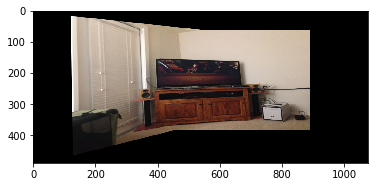

In [34]:
plt.imshow(cv2.cvtColor(s.leftImage,cv2.COLOR_BGR2RGB))